# Multi-seed Grokking Results Visualization

This notebook visualizes results from multi-seed grokking experiments.
Each plot shows:
- Train Accuracy (left y-axis)
- Test Accuracy (left y-axis)
- A specific metric (right y-axis): Complexity, LLC, L2 Norm, or Spectral Entropy

All plots show mean ± std over multiple seeds.


In [2]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


Generating plots: 9 tasks × 2 WDs × 6 metrics
Total: 108 figures

✗ Error in x+y WD=0.0: [Errno 13] Permission denied: '/root/autodl-tmp'
✗ Error in x+y WD=1.0: [Errno 13] Permission denied: '/root/autodl-tmp'
✗ Error in x-y WD=0.0: 'attention_spectral_entropy'
✗ Error in x-y WD=1.0: 'attention_spectral_entropy'
✗ Error in x*y WD=0.0: [Errno 13] Permission denied: '/root/autodl-tmp'
✗ Error in x*y WD=1.0: [Errno 13] Permission denied: '/root/autodl-tmp'
✗ Error in x_div_y WD=0.0: [Errno 13] Permission denied: '/root/autodl-tmp'
✗ Error in x_div_y WD=1.0: [Errno 13] Permission denied: '/root/autodl-tmp'
✗ Error in x2+y2 WD=0.0: [Errno 13] Permission denied: '/root/autodl-tmp'
✗ Error in x2+y2 WD=1.0: [Errno 13] Permission denied: '/root/autodl-tmp'
✗ Error in x2+xy+y2 WD=0.0: [Errno 13] Permission denied: '/root/autodl-tmp'
✗ Error in x2+xy+y2 WD=1.0: [Errno 13] Permission denied: '/root/autodl-tmp'
✗ Error in x2+xy+y2+x WD=0.0: [Errno 13] Permission denied: '/root/autodl-tmp'
✗ Error i

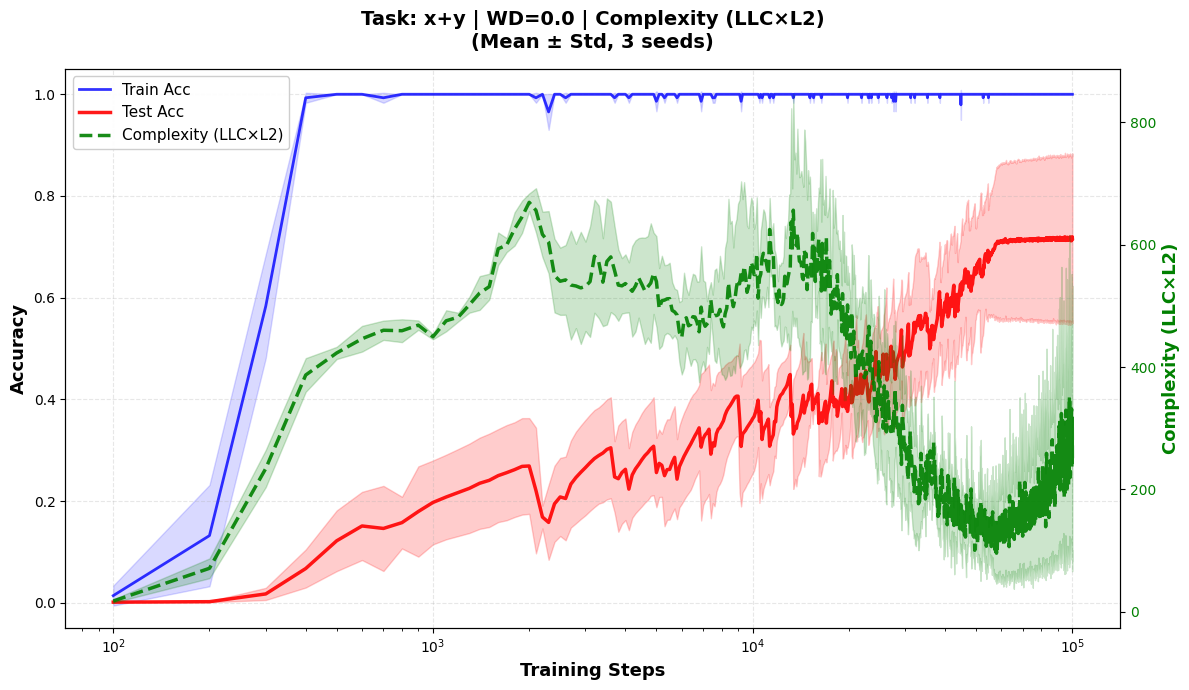

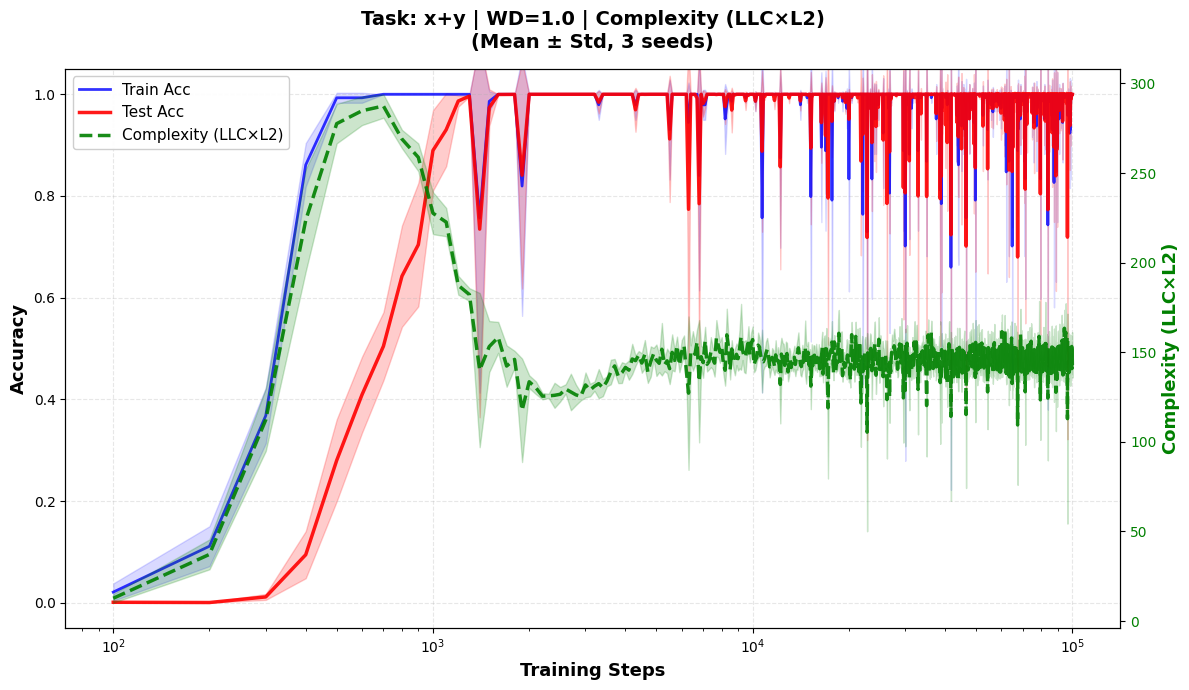

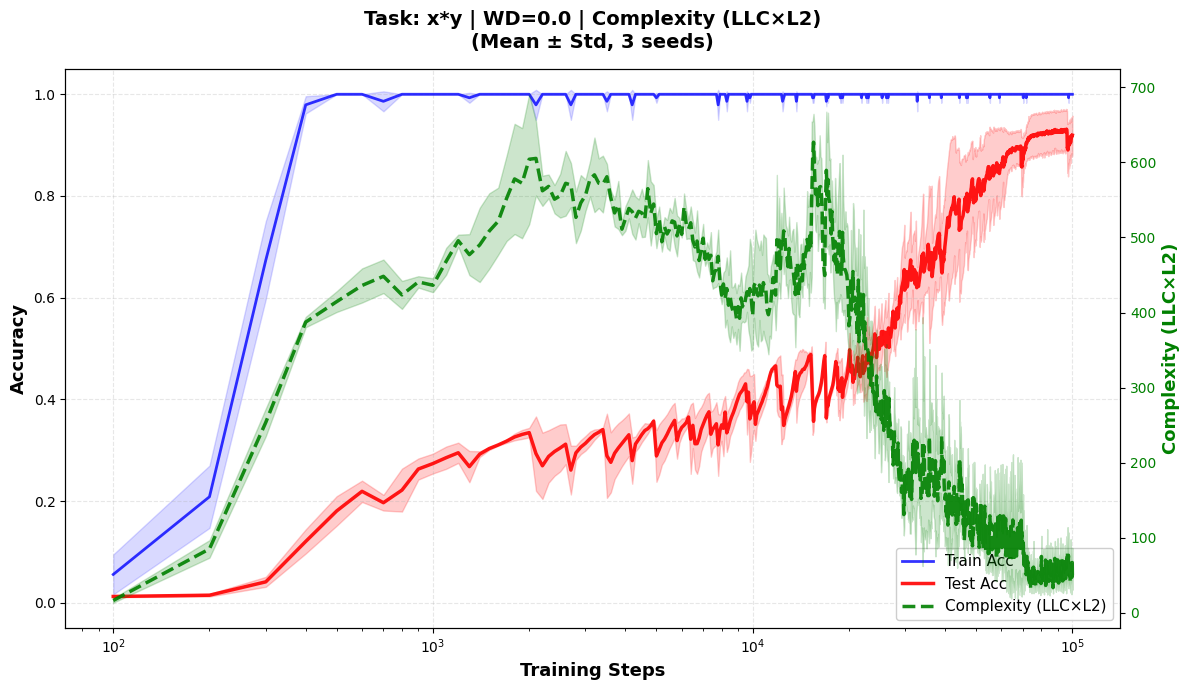

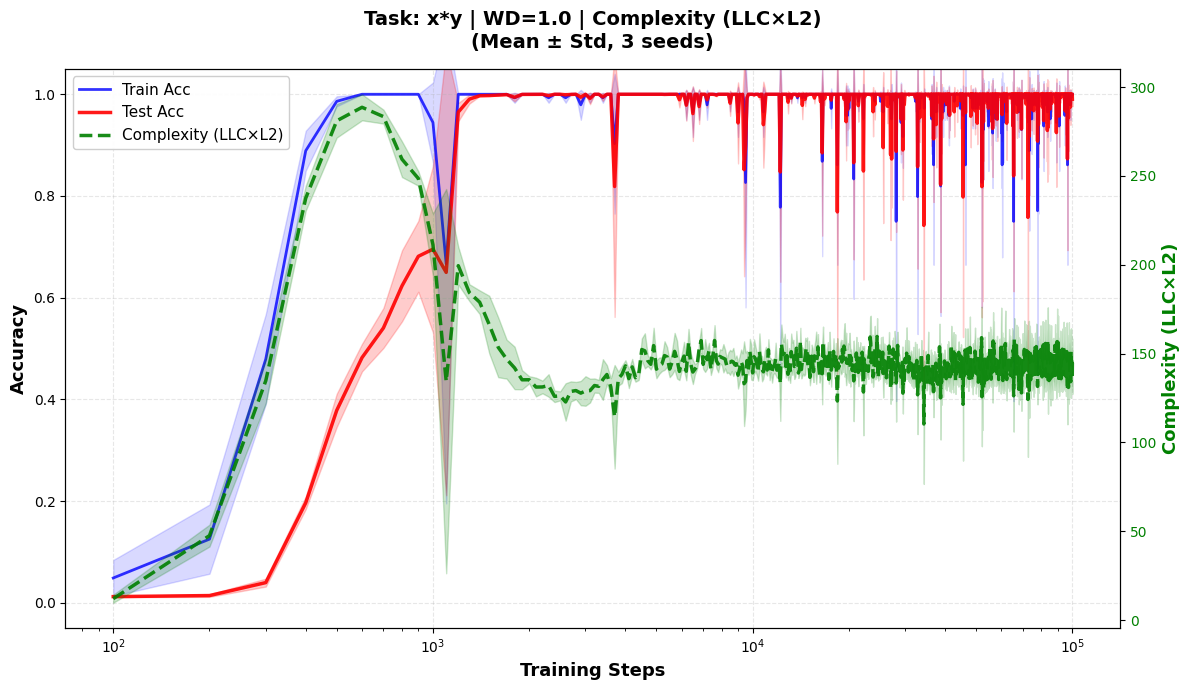

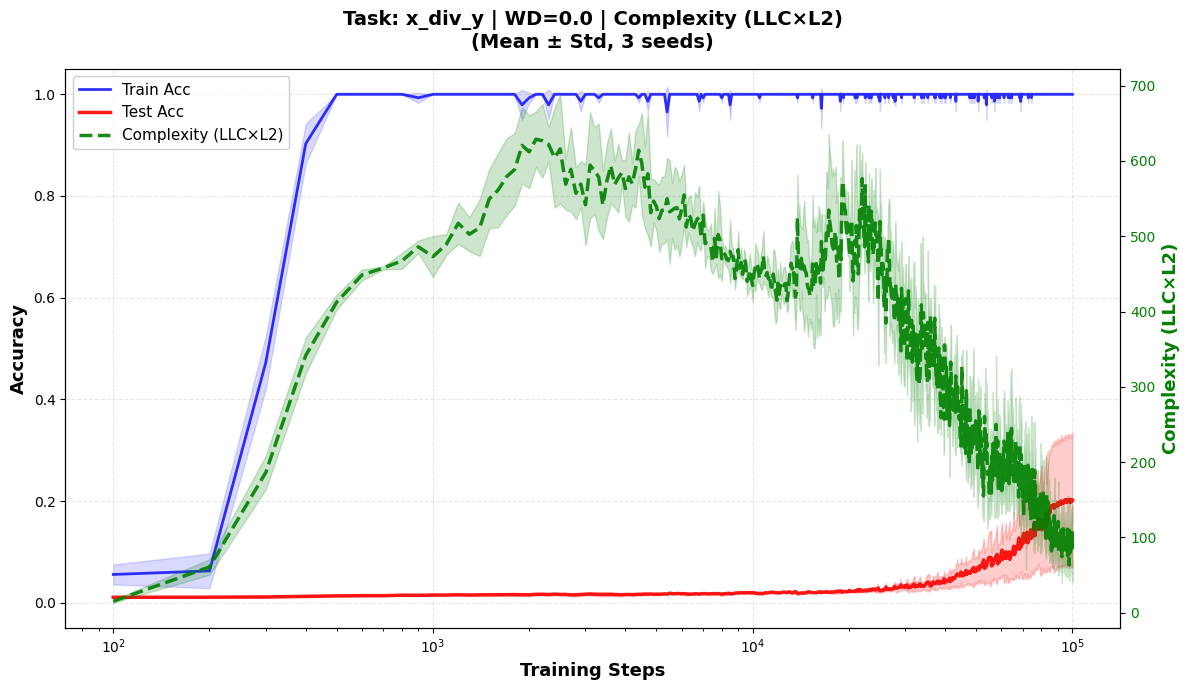

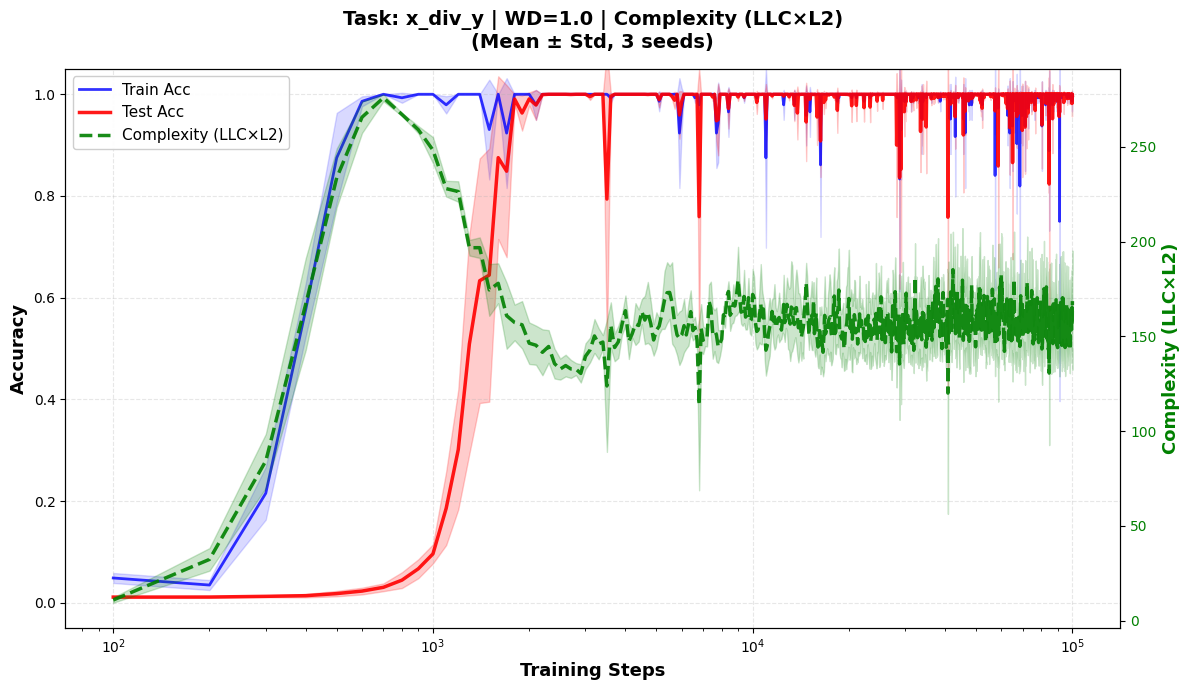

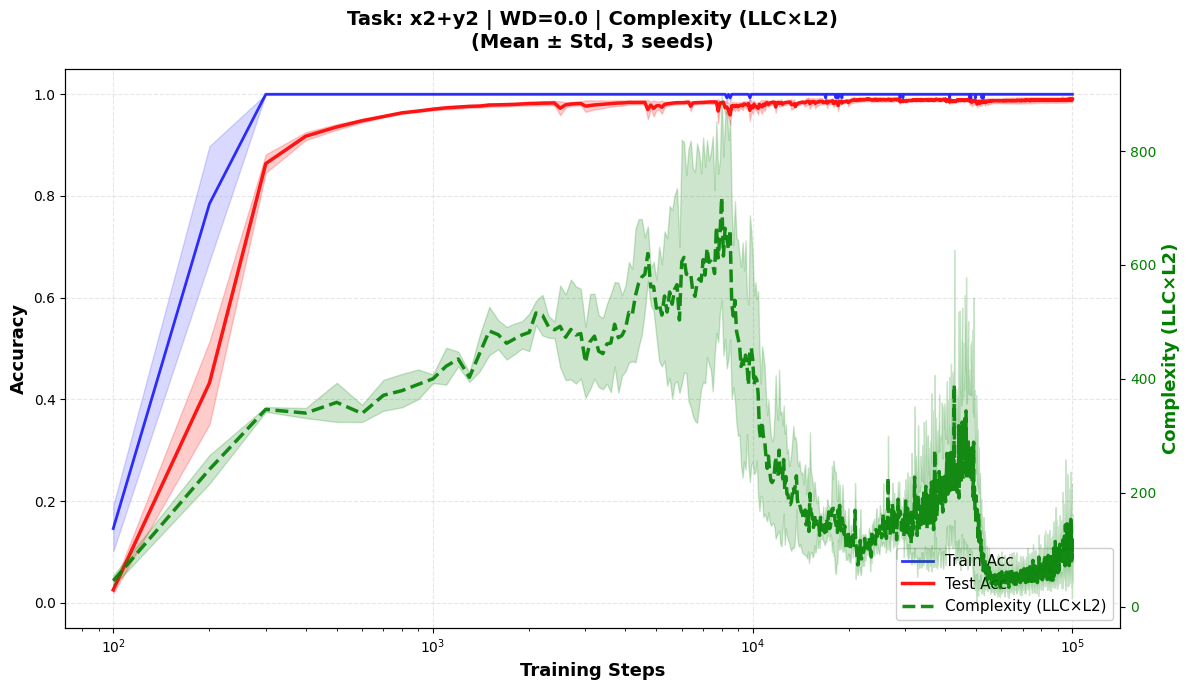

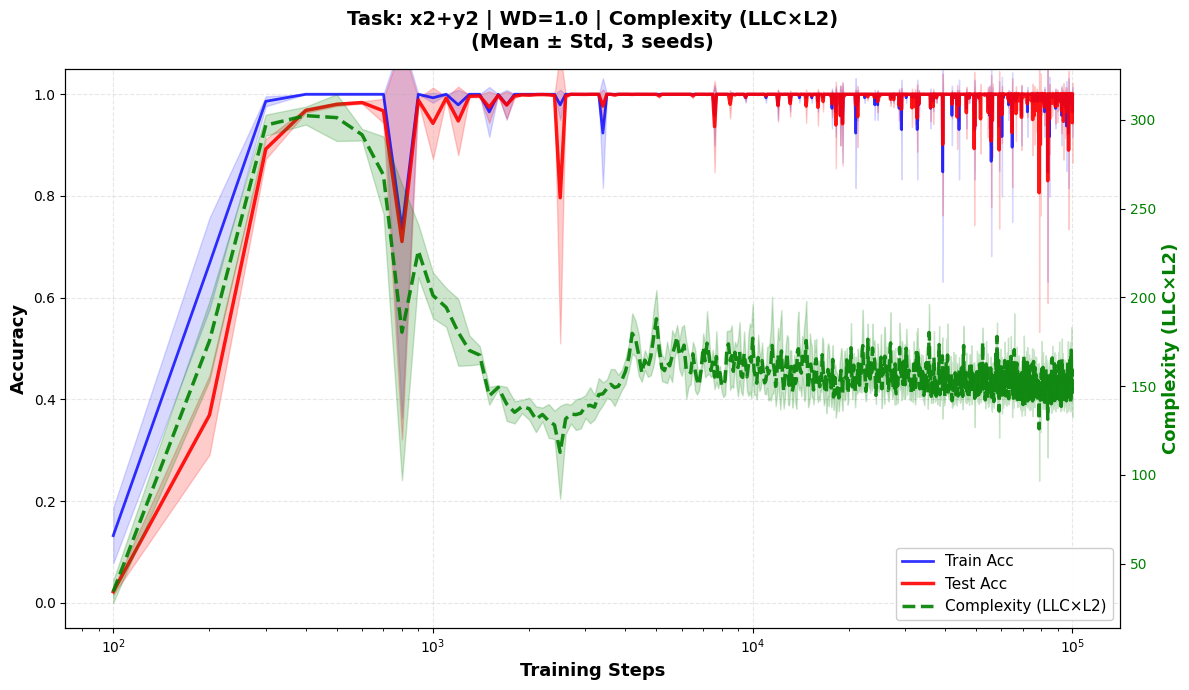

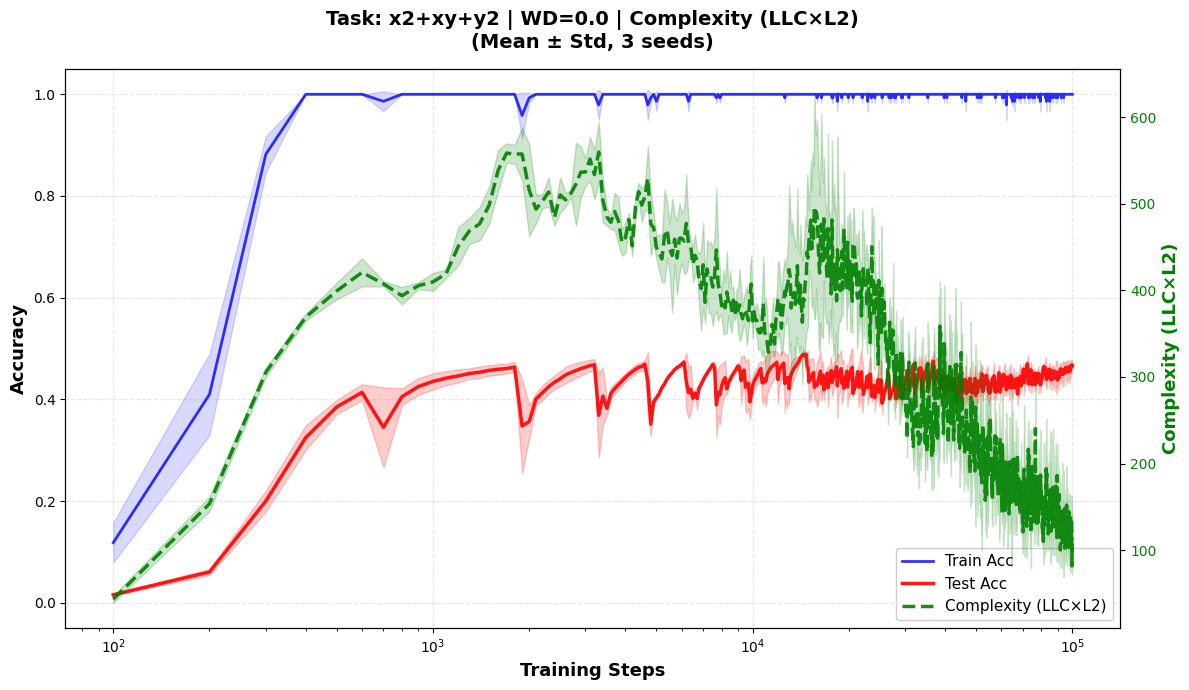

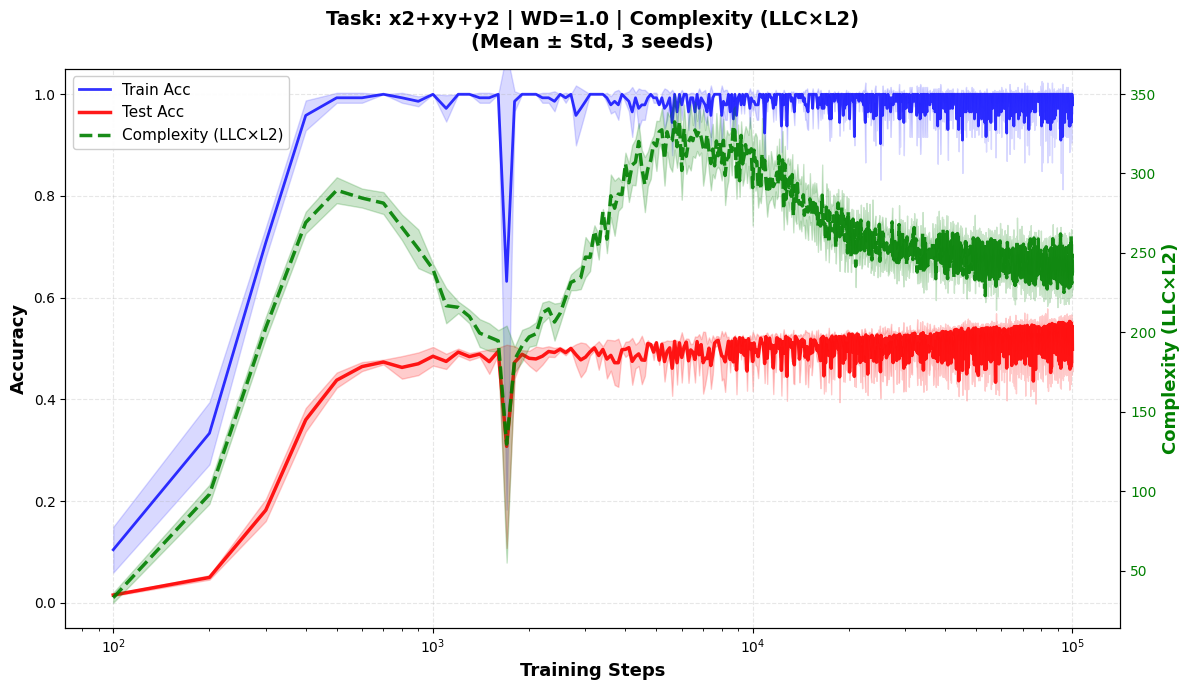

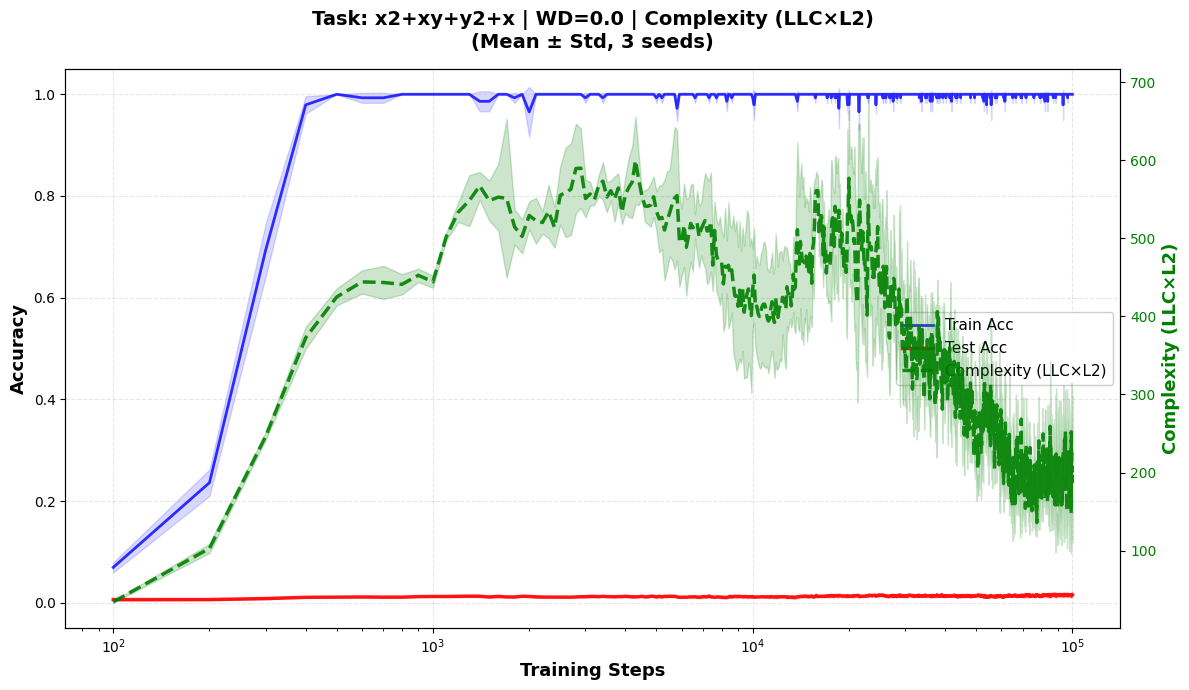

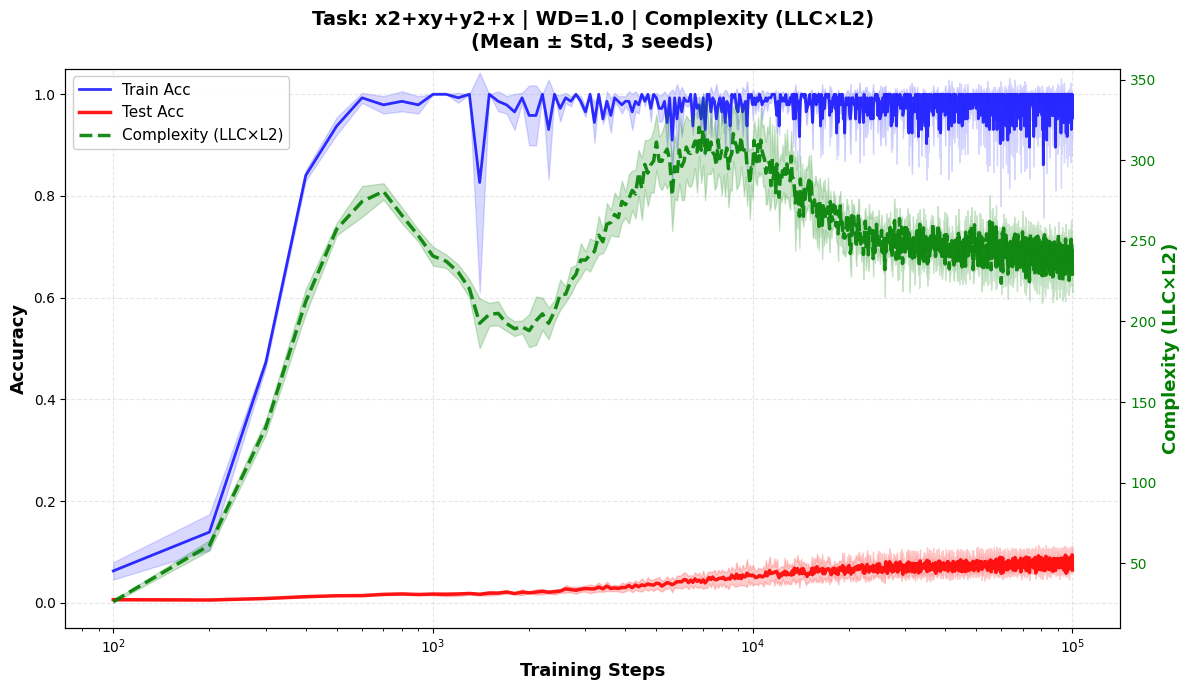

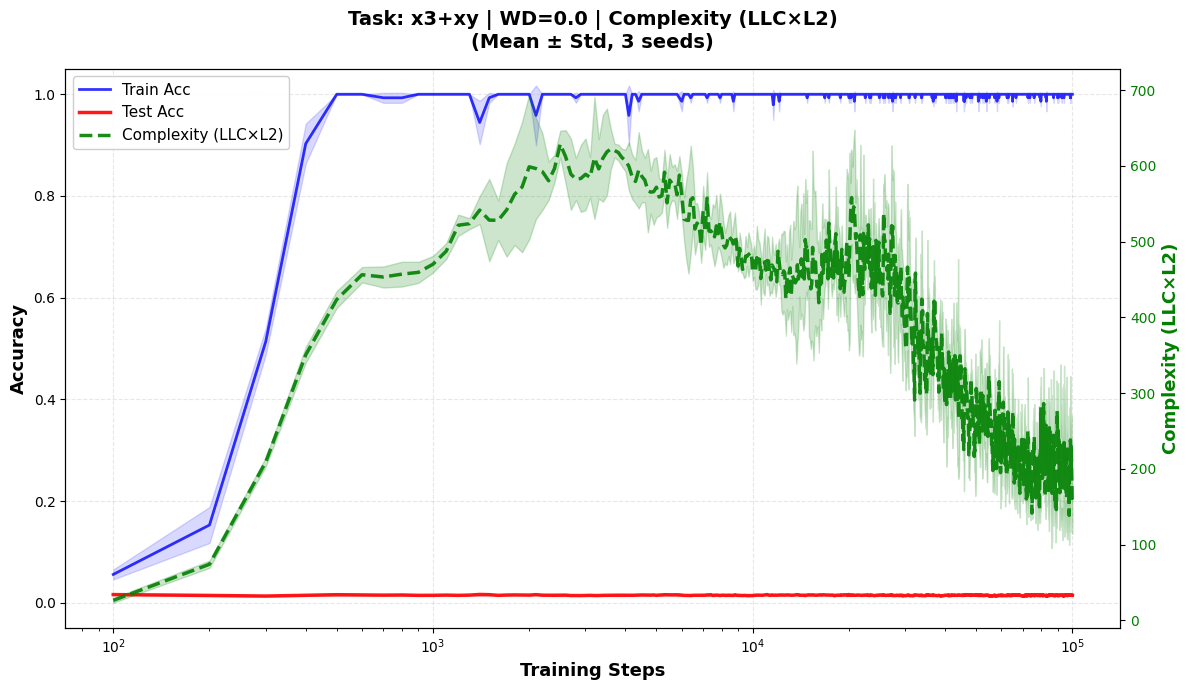

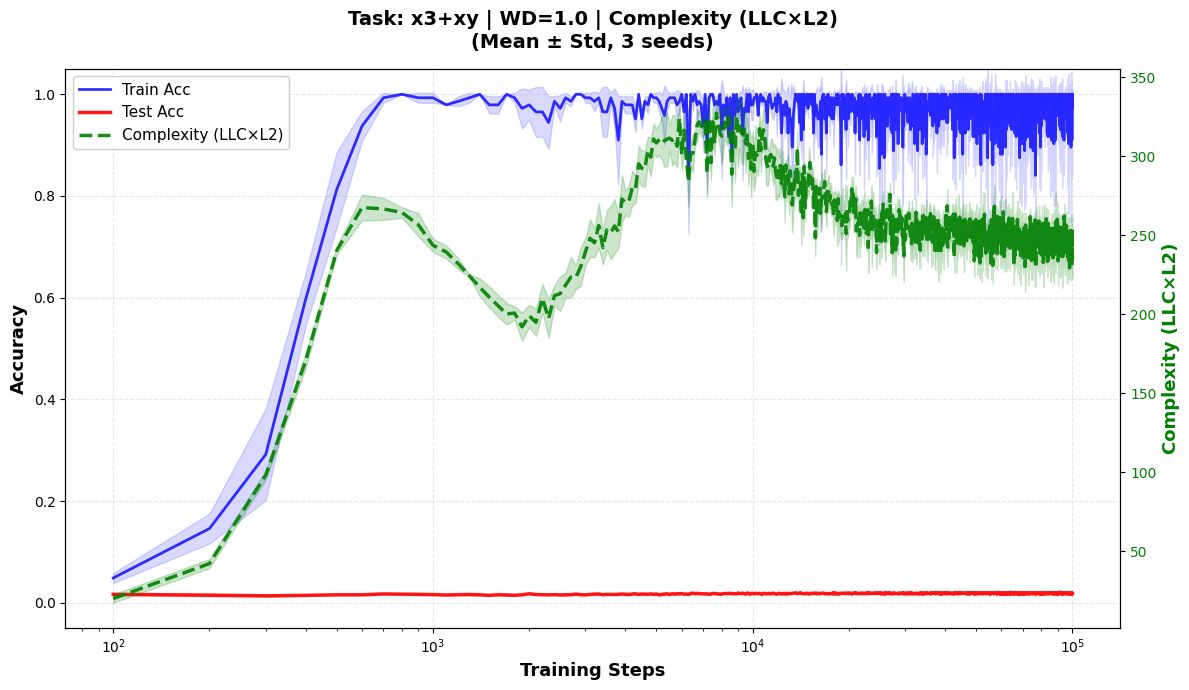

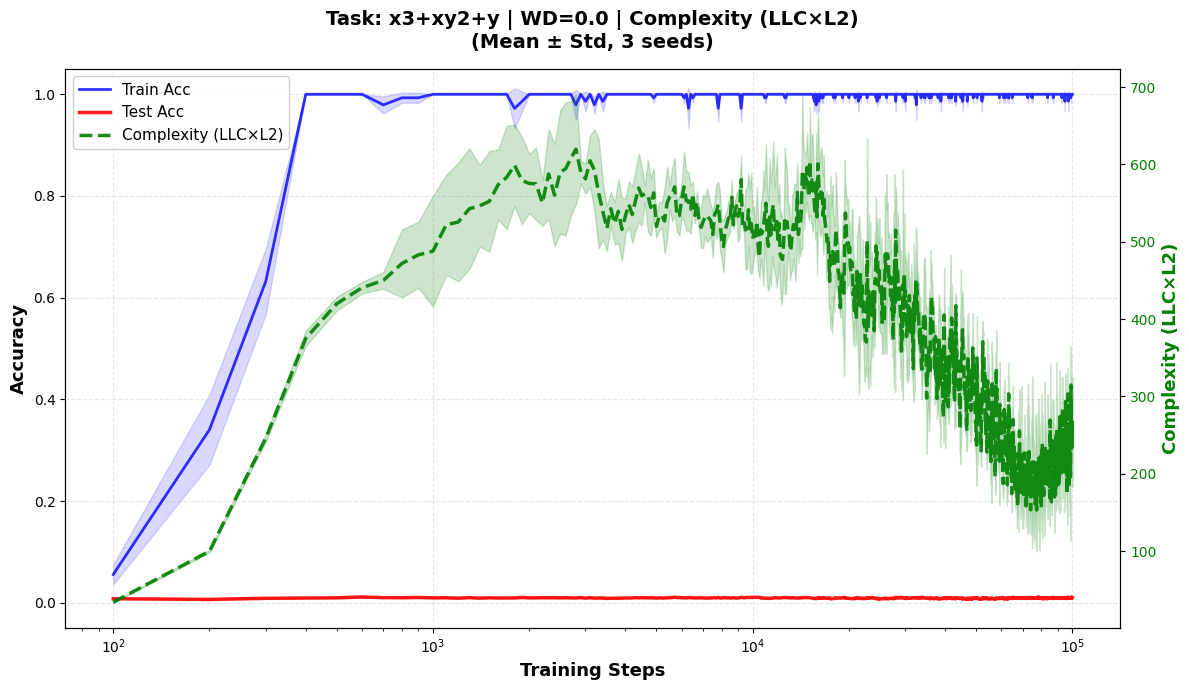

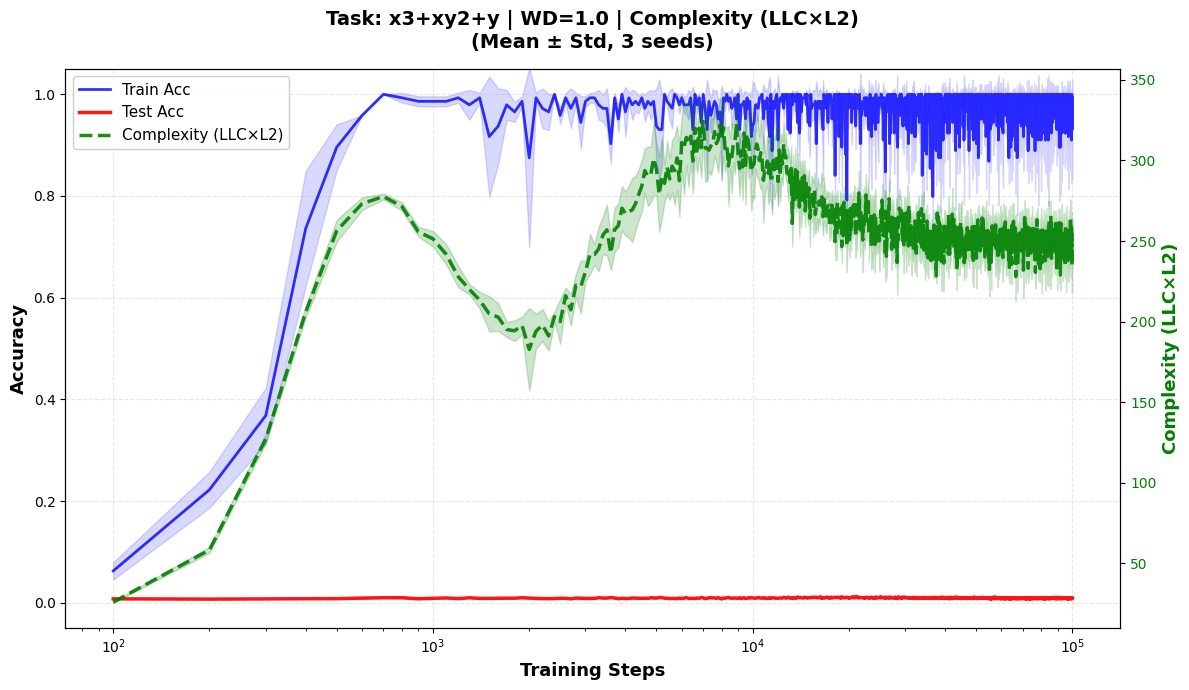

In [3]:
def plot_with_metric(task_name, wd, results_base="/data/zjj/test/results/data", save_dir=None):
    """绘制训练/测试acc + 各个单独指标的图"""
    task_safe = task_name.replace("/", "_div_").replace("*", "_mul_").replace("+", "_plus_")
    data_dir = Path(results_base) / task_safe / f"wd_{wd}"
    seed_files = sorted(list(data_dir.glob("seed*.csv")))
    
    if not seed_files:
        print(f"⚠ No data: {task_name} WD={wd}")
        return
    
    # 加载数据
    all_data = []
    for seed_file in seed_files:
        data = {}
        with open(seed_file, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                for key, value in row.items():
                    if key not in data: data[key] = []
                    data[key].append(float(value))
        all_data.append(data)
    
    # 计算统计量
    steps = np.array(all_data[0]['steps'])
    def stats(key):
        d = np.array([x[key] for x in all_data])
        return np.mean(d, axis=0), np.std(d, axis=0)
    
    train_acc_m, train_acc_s = stats('train_acc')
    test_acc_m, test_acc_s = stats('test_acc')
    llc_m, llc_s = stats('llc')
    l2_m, l2_s = stats('l2_norm')
    se_m, se_s = stats('spectral_entropy')
    attn_se_m, attn_se_s = stats('attention_spectral_entropy')
    emb_se_m, emb_se_s = stats('embedding_spectral_entropy')
    complexity_m = llc_m * l2_m
    complexity_s = np.sqrt((llc_s * l2_m)**2 + (llc_m * l2_s)**2)
    
    # 定义要绘制的指标
    metrics = [
        ('Complexity (LLC×L2)', complexity_m, complexity_s, 'green'),
        ('LLC', llc_m, llc_s, 'purple'),
        ('L2 Norm', l2_m, l2_s, 'orange'),
        ('Spectral Entropy', se_m, se_s, 'brown'),
        ('Attention Entropy', attn_se_m, attn_se_s, 'cyan'),
        ('Embedding Entropy', emb_se_m, emb_se_s, 'magenta'),
    ]
    
    # 为每个指标生成一张图
    for metric_name, metric_m, metric_s, color in metrics:
        fig, ax1 = plt.subplots(figsize=(12, 7))
        ax2 = ax1.twinx()
        
        # 左轴：训练和测试准确率
        line1 = ax1.plot(steps, train_acc_m, 'b-', label='Train Acc', linewidth=2, alpha=0.8)
        ax1.fill_between(steps, train_acc_m - train_acc_s, train_acc_m + train_acc_s, 
                         color='blue', alpha=0.15)
        line2 = ax1.plot(steps, test_acc_m, 'r-', label='Test Acc', linewidth=2.5, alpha=0.9)
        ax1.fill_between(steps, test_acc_m - test_acc_s, test_acc_m + test_acc_s, 
                         color='red', alpha=0.2)
        
        ax1.set_xlabel('Training Steps', fontsize=13, fontweight='bold')
        ax1.set_ylabel('Accuracy', fontsize=13, fontweight='bold', color='black')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.set_xscale('log')
        ax1.set_ylim(-0.05, 1.05)
        ax1.grid(True, alpha=0.3, linestyle='--')
        
        # 右轴：特定指标
        line3 = ax2.plot(steps, metric_m, color=color, linestyle='--', 
                        label=metric_name, linewidth=2.5, alpha=0.9)
        ax2.fill_between(steps, metric_m - metric_s, metric_m + metric_s, 
                         color=color, alpha=0.2)
        
        ax2.set_ylabel(metric_name, fontsize=13, fontweight='bold', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        
        # 合并图例
        lines = line1 + line2 + line3
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='best', fontsize=11, framealpha=0.95)
        
        # 标题
        plt.title(f'Task: {task_name} | WD={wd} | {metric_name}\n(Mean ± Std, {len(all_data)} seeds)', 
                 fontsize=14, fontweight='bold', pad=15)
        
        plt.tight_layout()
        
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            metric_safe = metric_name.replace(' ', '_').replace('(', '').replace(')', '').replace('×', 'x')
            save_path = os.path.join(save_dir, f"{task_safe}_wd{wd}_{metric_safe}.png")
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        
        plt.close()
    
    print(f"✓ {task_name:15s} WD={wd} → 6 plots generated")

# 批量绘制所有任务（9个任务 × 2个权重衰减 × 6个指标 = 108张图）
tasks = ['x+y', 'x-y', 'x*y', 'x_div_y', 'x2+y2', 'x2+xy+y2', 'x2+xy+y2+x', 'x3+xy', 'x3+xy2+y']
weight_decays = [0.0, 1.0]
save_base = '/root/autodl-tmp/test/results/plots'

print(f"{'='*70}")
print(f"Generating plots: {len(tasks)} tasks × {len(weight_decays)} WDs × 6 metrics")
print(f"Total: {len(tasks) * len(weight_decays) * 6} figures")
print(f"{'='*70}\n")

for task in tasks:
    for wd in weight_decays:
        try:
            plot_with_metric(task, wd, save_dir=save_base)
        except Exception as e:
            print(f"✗ Error in {task} WD={wd}: {e}")

print(f"\n{'='*70}")
print(f"All plots saved to: {save_base}")
print(f"{'='*70}")


In [ ]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_ROOT = Path("/data/zjj/test/results/data/x-y")
SAVE_ROOT = Path("/data/zjj/test/results/analysis_plots/x-y")
SAVE_ROOT.mkdir(parents=True, exist_ok=True)

BASE_KEYS = {"steps", "train_acc", "test_acc"}  # 必须存在的列

def load_seed_csv(seed_file: Path):
    data = {}
    with seed_file.open("r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            for k, v in row.items():
                data.setdefault(k, [])
                try:
                    data[k].append(float(v))
                except Exception:
                    data[k].append(np.nan)
    for k in data:
        data[k] = np.asarray(data[k], dtype=np.float64)
    return data

def align_and_stack(seed_dicts, key):
    """取所有seed的key序列，按最短长度对齐后stack，返回 [S, T]"""
    arrs = []
    for d in seed_dicts:
        if key not in d:
            return None
        arrs.append(d[key])
    min_len = min(len(a) for a in arrs)
    arrs = [a[:min_len] for a in arrs]
    return np.stack(arrs, axis=0)

def mean_std(seed_dicts, key):
    stk = align_and_stack(seed_dicts, key)
    if stk is None:
        return None, None
    m = np.nanmean(stk, axis=0)
    if stk.shape[0] == 1:
        s = np.zeros_like(m)
    else:
        s = np.nanstd(stk, axis=0)
    return m, s

def plot_acc_plus_metric(folder: Path):
    seed_files = sorted(folder.glob("seed*.csv"))
    if not seed_files:
        print(f"⚠ Skip (no seed*.csv): {folder}")
        return

    seed_dicts = [load_seed_csv(f) for f in seed_files]
    nseed = len(seed_files)

    # 必需列
    steps_m, _ = mean_std(seed_dicts, "steps")
    tr_m, tr_s = mean_std(seed_dicts, "train_acc")
    te_m, te_s = mean_std(seed_dicts, "test_acc")
    if steps_m is None or tr_m is None or te_m is None:
        print(f"⚠ Missing required columns in {folder} (need steps/train_acc/test_acc)")
        return

    # 找“其他指标”：取第一个seed的列集合更稳；再过滤 BASE_KEYS
    all_cols = set(seed_dicts[0].keys())
    extra_metrics = sorted([c for c in all_cols if c not in BASE_KEYS])

    # 输出目录
    out_dir = SAVE_ROOT / folder.name
    out_dir.mkdir(parents=True, exist_ok=True)

    # 过滤 log-x 无效点
    base_mask = steps_m > 0
    steps = steps_m[base_mask]
    tr_m0, tr_s0 = tr_m[base_mask], tr_s[base_mask]
    te_m0, te_s0 = te_m[base_mask], te_s[base_mask]

    # 如果没有额外指标，就至少画一张纯acc
    if len(extra_metrics) == 0:
        plt.figure(figsize=(10, 6))
        plt.plot(steps, tr_m0, label="Train Acc", linewidth=2)
        if np.any(tr_s0 > 0):
            plt.fill_between(steps, tr_m0 - tr_s0, tr_m0 + tr_s0, alpha=0.15)
        plt.plot(steps, te_m0, label="Test Acc", linewidth=2)
        if np.any(te_s0 > 0):
            plt.fill_between(steps, te_m0 - te_s0, te_m0 + te_s0, alpha=0.15)
        plt.xscale("log")
        plt.ylim(-0.05, 1.05)
        plt.grid(True, alpha=0.3, linestyle="--")
        plt.xlabel("Training Steps (log)")
        plt.ylabel("Accuracy")
        plt.title(f"x-y | {folder.name} | n_seeds={nseed}")
        plt.legend(loc="best")
        out_path = out_dir / f"x-y_{folder.name}_acc.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
        plt.close()
        print(f"✓ Saved: {out_path}")
        return

    # 对每个额外指标，画 “Acc(左轴) + 指标(右轴)” 的合并图
    for metric in extra_metrics:
        m_m, m_s = mean_std(seed_dicts, metric)
        if m_m is None:
            continue

        m_m = m_m[base_mask]
        m_s = m_s[base_mask]

        fig, ax1 = plt.subplots(figsize=(12, 7))
        ax2 = ax1.twinx()

        # 左轴：Acc
        l1 = ax1.plot(steps, tr_m0, label="Train Acc", linewidth=2)
        if np.any(tr_s0 > 0):
            ax1.fill_between(steps, tr_m0 - tr_s0, tr_m0 + tr_s0, alpha=0.15)

        l2 = ax1.plot(steps, te_m0, label="Test Acc", linewidth=2)
        if np.any(te_s0 > 0):
            ax1.fill_between(steps, te_m0 - te_s0, te_m0 + te_s0, alpha=0.15)

        ax1.set_xscale("log")
        ax1.set_ylim(-0.05, 1.05)
        ax1.grid(True, alpha=0.3, linestyle="--")
        ax1.set_xlabel("Training Steps (log)")
        ax1.set_ylabel("Accuracy")

        # 右轴：metric（不指定颜色，交给matplotlib默认循环；避免你后续风格统一麻烦）
        l3 = ax2.plot(steps, m_m, linestyle="--", linewidth=2, label=metric)
        if np.any(m_s > 0):
            ax2.fill_between(steps, m_m - m_s, m_m + m_s, alpha=0.15)

        ax2.set_ylabel(metric)

        # 合并图例
        lines = l1 + l2 + l3
        labels = [ln.get_label() for ln in lines]
        ax1.legend(lines, labels, loc="best")

        fig.suptitle(f"x-y | {folder.name} | {metric} | n_seeds={nseed}")
        fig.tight_layout()

        metric_safe = metric.replace(" ", "_").replace("/", "_").replace("(", "").replace(")", "").replace("×", "x")
        out_path = out_dir / f"x-y_{folder.name}_acc_plus_{metric_safe}.png"
        fig.savefig(out_path, dpi=150, bbox_inches="tight")
        plt.close(fig)

    print(f"✓ Done folder: {folder.name} | seeds={nseed} | extra_metrics={len(extra_metrics)}")

# 遍历 x-y 下所有子文件夹
subdirs = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()])
print(f"Found {len(subdirs)} subfolders under: {DATA_ROOT}")

for folder in subdirs:
    plot_acc_plus_metric(folder)

print(f"\nAll plots saved to: {SAVE_ROOT}")


Found 12 subfolders under: /data/zjj/test/results/data/x-y
✓ Saved: /data/zjj/test/results/analysis_plots/x-y/x-y_asam_acc.png
✓ Saved: /data/zjj/test/results/analysis_plots/x-y/x-y_ema_acc.png
✓ Saved: /data/zjj/test/results/analysis_plots/x-y/x-y_flooding_acc.png
✓ Saved: /data/zjj/test/results/analysis_plots/x-y/x-y_gsam_acc.png
✓ Saved: /data/zjj/test/results/analysis_plots/x-y/x-y_logit_norm_acc.png
✓ Saved: /data/zjj/test/results/analysis_plots/x-y/x-y_saf_acc.png
✓ Saved: /data/zjj/test/results/analysis_plots/x-y/x-y_sam_acc.png
✓ Saved: /data/zjj/test/results/analysis_plots/x-y/x-y_si_llc_acc.png
✓ Saved: /data/zjj/test/results/analysis_plots/x-y/x-y_spectral_decoupling_acc.png
✓ Saved: /data/zjj/test/results/analysis_plots/x-y/x-y_swa_acc.png
✓ Saved: /data/zjj/test/results/analysis_plots/x-y/x-y_wd_0.0_acc.png
✓ Saved: /data/zjj/test/results/analysis_plots/x-y/x-y_wd_1.0_acc.png

All plots saved to: /data/zjj/test/results/analysis_plots/x-y
